### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 5  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")



Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [00:54<76:15:06, 54.91s/it]

Entrenando:   0%|          | 2/5000 [02:01<85:54:10, 61.87s/it]

Entrenando:   0%|          | 3/5000 [03:07<88:39:30, 63.87s/it]

Entrenando:   0%|          | 4/5000 [04:13<89:39:44, 64.61s/it]

Entrenando:   0%|          | 5/5000 [05:20<90:48:12, 65.44s/it]

Entrenando:   0%|          | 6/5000 [06:32<93:54:34, 67.70s/it]

Entrenando:   0%|          | 7/5000 [07:36<92:12:59, 66.49s/it]

Entrenando:   0%|          | 8/5000 [08:47<94:07:56, 67.88s/it]

Entrenando:   0%|          | 9/5000 [10:03<97:24:37, 70.26s/it]

Entrenando:   0%|          | 10/5000 [11:15<98:26:05, 71.02s/it]

Entrenando:   0%|          | 11/5000 [12:29<99:37:08, 71.88s/it]

Entrenando:   0%|          | 12/5000 [13:40<99:03:52, 71.50s/it]

Entrenando:   0%|          | 13/5000 [15:01<103:12:20, 74.50s/it]

Entrenando:   0%|          | 14/5000 [16:41<113:36:59, 82.03s/it]

Entrenando:   0%|          | 15/5000 [18:22<121:50:59, 88.00s/it]

Entrenando:   0%|          | 16/5000 [20:05<127:59:34, 92.45s/it]

Entrenando:   0%|          | 17/5000 [21:50<133:13:36, 96.25s/it]

Entrenando:   0%|          | 18/5000 [23:54<144:38:21, 104.52s/it]

Entrenando:   0%|          | 19/5000 [25:51<149:53:25, 108.33s/it]

Entrenando:   0%|          | 20/5000 [27:41<150:35:37, 108.86s/it]

Entrenando:   0%|          | 21/5000 [29:25<148:24:46, 107.31s/it]

Entrenando:   0%|          | 22/5000 [31:16<150:05:06, 108.54s/it]

Entrenando:   0%|          | 23/5000 [33:09<151:44:31, 109.76s/it]

Entrenando:   0%|          | 24/5000 [35:10<156:16:41, 113.06s/it]

Entrenando:   0%|          | 25/5000 [37:12<160:00:17, 115.78s/it]

Entrenando:   1%|          | 26/5000 [39:42<174:16:49, 126.14s/it]

Entrenando:   1%|          | 27/5000 [42:04<180:33:13, 130.70s/it]

Entrenando:   1%|          | 28/5000 [44:19<182:40:54, 132.27s/it]

Entrenando:   1%|          | 29/5000 [46:36<184:24:29, 133.55s/it]

Entrenando:   1%|          | 30/5000 [48:52<185:16:30, 134.20s/it]

Entrenando:   1%|          | 31/5000 [51:06<185:22:59, 134.31s/it]

Entrenando:   1%|          | 32/5000 [53:20<185:10:34, 134.19s/it]

Entrenando:   1%|          | 33/5000 [55:35<185:24:35, 134.38s/it]

Entrenando:   1%|          | 34/5000 [57:51<185:54:24, 134.77s/it]

Entrenando:   1%|          | 35/5000 [1:00:07<186:25:30, 135.17s/it]

Entrenando:   1%|          | 36/5000 [1:02:22<186:31:07, 135.27s/it]

Entrenando:   1%|          | 37/5000 [1:04:38<186:49:33, 135.52s/it]

Entrenando:   1%|          | 38/5000 [1:06:54<186:46:41, 135.51s/it]

Entrenando:   1%|          | 39/5000 [1:09:17<190:00:09, 137.88s/it]

Entrenando:   1%|          | 40/5000 [1:11:39<191:29:21, 138.98s/it]

Entrenando:   1%|          | 41/5000 [1:14:04<193:51:01, 140.73s/it]

Entrenando:   1%|          | 42/5000 [1:16:23<193:11:03, 140.27s/it]

Entrenando:   1%|          | 43/5000 [1:18:48<195:02:10, 141.64s/it]

Entrenando:   1%|          | 44/5000 [1:21:15<197:08:56, 143.21s/it]

Entrenando:   1%|          | 45/5000 [1:23:36<196:18:18, 142.62s/it]

Entrenando:   1%|          | 46/5000 [1:25:54<194:32:45, 141.37s/it]

Entrenando:   1%|          | 47/5000 [1:28:06<190:33:41, 138.51s/it]

Entrenando:   1%|          | 48/5000 [1:30:19<188:03:10, 136.71s/it]

Entrenando:   1%|          | 49/5000 [1:32:21<182:02:41, 132.37s/it]

Entrenando:   1%|          | 50/5000 [1:34:19<176:07:22, 128.09s/it]

Iter  50: train_loss=2.5165, val_loss=2.3914, train_suc=0.435, train_err=0.277, train_inc=0.287 | val_suc=0.463, val_err=0.260, val_inc=0.277


Entrenando:   1%|          | 51/5000 [1:36:17<172:01:50, 125.14s/it]

Entrenando:   1%|          | 52/5000 [1:38:07<165:43:57, 120.58s/it]

Entrenando:   1%|          | 53/5000 [1:39:51<158:39:58, 115.46s/it]

Entrenando:   1%|          | 54/5000 [1:41:37<154:55:18, 112.76s/it]

Entrenando:   1%|          | 55/5000 [1:43:20<150:47:46, 109.78s/it]

Entrenando:   1%|          | 56/5000 [1:45:05<148:52:32, 108.40s/it]

Entrenando:   1%|          | 57/5000 [1:46:45<145:24:17, 105.90s/it]

Entrenando:   1%|          | 58/5000 [1:48:21<141:21:33, 102.97s/it]

Entrenando:   1%|          | 59/5000 [1:50:03<140:57:08, 102.70s/it]

Entrenando:   1%|          | 60/5000 [1:51:42<139:20:19, 101.54s/it]

Entrenando:   1%|          | 61/5000 [1:53:25<139:59:58, 102.04s/it]

Entrenando:   1%|          | 62/5000 [1:55:08<140:10:00, 102.19s/it]

Entrenando:   1%|▏         | 63/5000 [1:56:54<141:36:07, 103.25s/it]

Entrenando:   1%|▏         | 64/5000 [1:58:51<147:11:54, 107.36s/it]

Entrenando:   1%|▏         | 65/5000 [2:00:43<149:23:20, 108.98s/it]

Entrenando:   1%|▏         | 66/5000 [2:02:24<145:45:18, 106.35s/it]

Entrenando:   1%|▏         | 67/5000 [2:04:12<146:40:22, 107.04s/it]

Entrenando:   1%|▏         | 68/5000 [2:05:54<144:24:45, 105.41s/it]

Entrenando:   1%|▏         | 69/5000 [2:07:50<148:34:26, 108.47s/it]

Entrenando:   1%|▏         | 70/5000 [2:09:33<146:19:33, 106.85s/it]

Entrenando:   1%|▏         | 71/5000 [2:11:15<144:37:17, 105.63s/it]

Entrenando:   1%|▏         | 72/5000 [2:12:56<142:23:54, 104.02s/it]

Entrenando:   1%|▏         | 73/5000 [2:14:28<137:28:31, 100.45s/it]

Entrenando:   1%|▏         | 74/5000 [2:15:59<133:41:36, 97.71s/it] 

Entrenando:   2%|▏         | 75/5000 [2:17:31<131:23:54, 96.05s/it]

Entrenando:   2%|▏         | 76/5000 [2:19:02<129:22:54, 94.59s/it]

Entrenando:   2%|▏         | 77/5000 [2:20:35<128:26:05, 93.92s/it]

Entrenando:   2%|▏         | 78/5000 [2:22:06<127:27:38, 93.23s/it]

Entrenando:   2%|▏         | 79/5000 [2:23:37<126:22:52, 92.46s/it]

Entrenando:   2%|▏         | 80/5000 [2:25:07<125:29:27, 91.82s/it]

Entrenando:   2%|▏         | 81/5000 [2:26:33<123:03:34, 90.06s/it]

Entrenando:   2%|▏         | 82/5000 [2:27:55<119:36:58, 87.56s/it]

Entrenando:   2%|▏         | 83/5000 [2:29:17<117:22:36, 85.94s/it]

Entrenando:   2%|▏         | 84/5000 [2:30:40<116:01:12, 84.96s/it]

Entrenando:   2%|▏         | 85/5000 [2:31:58<113:22:12, 83.04s/it]

Entrenando:   2%|▏         | 86/5000 [2:33:13<110:00:44, 80.60s/it]

Entrenando:   2%|▏         | 87/5000 [2:34:30<108:23:38, 79.43s/it]

Entrenando:   2%|▏         | 88/5000 [2:35:45<106:43:38, 78.22s/it]

Entrenando:   2%|▏         | 89/5000 [2:37:00<105:06:09, 77.05s/it]

Entrenando:   2%|▏         | 90/5000 [2:38:16<104:36:09, 76.69s/it]

Entrenando:   2%|▏         | 91/5000 [2:39:31<103:55:13, 76.21s/it]

Entrenando:   2%|▏         | 92/5000 [2:40:38<100:21:55, 73.62s/it]

Entrenando:   2%|▏         | 93/5000 [2:41:45<97:20:49, 71.42s/it] 

Entrenando:   2%|▏         | 94/5000 [2:42:59<98:24:40, 72.21s/it]

Entrenando:   2%|▏         | 95/5000 [2:44:04<95:23:13, 70.01s/it]

Entrenando:   2%|▏         | 96/5000 [2:45:17<96:41:50, 70.99s/it]

Entrenando:   2%|▏         | 97/5000 [2:46:25<95:39:31, 70.24s/it]

Entrenando:   2%|▏         | 98/5000 [2:47:31<93:43:41, 68.83s/it]

Entrenando:   2%|▏         | 99/5000 [2:48:44<95:27:55, 70.12s/it]

Entrenando:   2%|▏         | 100/5000 [2:49:51<94:23:26, 69.35s/it]

Iter 100: train_loss=1.7855, val_loss=1.4542, train_suc=0.647, train_err=0.210, train_inc=0.143 | val_suc=0.689, val_err=0.173, val_inc=0.138
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:50:58<93:06:13, 68.42s/it]

Entrenando:   2%|▏         | 102/5000 [2:52:07<93:33:17, 68.76s/it]

Entrenando:   2%|▏         | 103/5000 [2:53:20<94:58:00, 69.81s/it]

Entrenando:   2%|▏         | 104/5000 [2:54:32<95:56:19, 70.54s/it]

Entrenando:   2%|▏         | 105/5000 [2:55:33<92:09:50, 67.78s/it]

Entrenando:   2%|▏         | 106/5000 [2:56:37<90:20:16, 66.45s/it]

Entrenando:   2%|▏         | 107/5000 [2:57:49<92:35:07, 68.12s/it]

Entrenando:   2%|▏         | 108/5000 [2:59:10<98:09:18, 72.23s/it]

Entrenando:   2%|▏         | 109/5000 [3:00:18<96:14:42, 70.84s/it]

Entrenando:   2%|▏         | 110/5000 [3:01:23<93:51:18, 69.10s/it]

Entrenando:   2%|▏         | 111/5000 [3:02:34<94:25:23, 69.53s/it]

Entrenando:   2%|▏         | 112/5000 [3:03:46<95:42:47, 70.49s/it]

Entrenando:   2%|▏         | 113/5000 [3:04:54<94:38:08, 69.71s/it]

Entrenando:   2%|▏         | 114/5000 [3:06:02<93:59:52, 69.26s/it]

Entrenando:   2%|▏         | 115/5000 [3:07:13<94:36:15, 69.72s/it]

Entrenando:   2%|▏         | 116/5000 [3:08:30<97:29:39, 71.86s/it]

Entrenando:   2%|▏         | 117/5000 [3:09:38<95:51:58, 70.68s/it]

Entrenando:   2%|▏         | 118/5000 [3:10:50<96:25:56, 71.11s/it]

Entrenando:   2%|▏         | 119/5000 [3:11:59<95:32:45, 70.47s/it]

Entrenando:   2%|▏         | 120/5000 [3:13:11<96:00:36, 70.83s/it]

Entrenando:   2%|▏         | 121/5000 [3:14:24<96:55:29, 71.52s/it]

Entrenando:   2%|▏         | 122/5000 [3:15:36<96:59:41, 71.58s/it]

Entrenando:   2%|▏         | 123/5000 [3:16:46<96:34:48, 71.29s/it]

Entrenando:   2%|▏         | 124/5000 [3:17:58<96:49:23, 71.49s/it]

Entrenando:   2%|▎         | 125/5000 [3:19:11<97:21:15, 71.89s/it]

Entrenando:   3%|▎         | 126/5000 [3:20:13<93:30:48, 69.07s/it]

Entrenando:   3%|▎         | 127/5000 [3:21:21<92:46:26, 68.54s/it]

Entrenando:   3%|▎         | 128/5000 [3:22:31<93:37:06, 69.18s/it]

Entrenando:   3%|▎         | 129/5000 [3:23:40<93:20:17, 68.98s/it]

Entrenando:   3%|▎         | 130/5000 [3:24:56<96:20:31, 71.22s/it]

Entrenando:   3%|▎         | 131/5000 [3:26:05<95:28:06, 70.59s/it]

Entrenando:   3%|▎         | 132/5000 [3:27:16<95:16:48, 70.46s/it]

Entrenando:   3%|▎         | 133/5000 [3:28:28<96:12:27, 71.16s/it]

Entrenando:   3%|▎         | 134/5000 [3:29:32<92:57:47, 68.78s/it]

Entrenando:   3%|▎         | 135/5000 [3:30:39<92:24:51, 68.38s/it]

Entrenando:   3%|▎         | 136/5000 [3:31:59<97:00:58, 71.80s/it]

Entrenando:   3%|▎         | 137/5000 [3:33:07<95:40:15, 70.82s/it]

Entrenando:   3%|▎         | 138/5000 [3:34:13<93:39:48, 69.35s/it]

Entrenando:   3%|▎         | 139/5000 [3:35:21<93:04:19, 68.93s/it]

Entrenando:   3%|▎         | 140/5000 [3:36:29<92:33:34, 68.56s/it]

Entrenando:   3%|▎         | 141/5000 [3:37:41<93:52:37, 69.55s/it]

Entrenando:   3%|▎         | 142/5000 [3:38:46<92:06:15, 68.25s/it]

Entrenando:   3%|▎         | 143/5000 [3:40:03<95:35:22, 70.85s/it]

Entrenando:   3%|▎         | 144/5000 [3:41:18<97:20:47, 72.17s/it]

Entrenando:   3%|▎         | 145/5000 [3:42:27<95:47:30, 71.03s/it]

Entrenando:   3%|▎         | 146/5000 [3:43:40<96:47:00, 71.78s/it]

Entrenando:   3%|▎         | 147/5000 [3:44:50<95:53:16, 71.13s/it]

Entrenando:   3%|▎         | 148/5000 [3:45:52<92:07:21, 68.35s/it]

Entrenando:   3%|▎         | 149/5000 [3:47:05<94:14:42, 69.94s/it]

Entrenando:   3%|▎         | 150/5000 [3:48:10<92:16:43, 68.50s/it]

Iter 150: train_loss=1.3204, val_loss=1.1300, train_suc=0.742, train_err=0.214, train_inc=0.044 | val_suc=0.790, val_err=0.167, val_inc=0.042


Entrenando:   3%|▎         | 151/5000 [3:49:19<92:24:46, 68.61s/it]

Entrenando:   3%|▎         | 152/5000 [3:50:31<93:49:48, 69.68s/it]

Entrenando:   3%|▎         | 153/5000 [3:51:41<93:51:38, 69.71s/it]

Entrenando:   3%|▎         | 154/5000 [3:52:56<95:52:03, 71.22s/it]

Entrenando:   3%|▎         | 155/5000 [3:54:03<94:13:12, 70.01s/it]

Entrenando:   3%|▎         | 156/5000 [3:55:20<96:51:55, 71.99s/it]

Entrenando:   3%|▎         | 157/5000 [3:56:23<93:20:38, 69.39s/it]

Entrenando:   3%|▎         | 158/5000 [3:57:27<91:15:07, 67.85s/it]

Entrenando:   3%|▎         | 159/5000 [3:58:41<93:38:27, 69.64s/it]

Entrenando:   3%|▎         | 160/5000 [3:59:50<93:29:27, 69.54s/it]

Entrenando:   3%|▎         | 161/5000 [4:00:53<90:32:12, 67.36s/it]

Entrenando:   3%|▎         | 162/5000 [4:02:07<93:08:45, 69.31s/it]

Entrenando:   3%|▎         | 163/5000 [4:03:20<94:54:23, 70.64s/it]

Entrenando:   3%|▎         | 164/5000 [4:04:30<94:23:08, 70.26s/it]

Entrenando:   3%|▎         | 165/5000 [4:05:43<95:43:17, 71.27s/it]

Entrenando:   3%|▎         | 166/5000 [4:06:50<93:58:04, 69.98s/it]

Entrenando:   3%|▎         | 167/5000 [4:08:05<95:44:00, 71.31s/it]

Entrenando:   3%|▎         | 168/5000 [4:09:21<97:39:17, 72.76s/it]

Entrenando:   3%|▎         | 169/5000 [4:10:34<97:38:42, 72.76s/it]

Entrenando:   3%|▎         | 170/5000 [4:11:47<97:48:54, 72.91s/it]

Entrenando:   3%|▎         | 171/5000 [4:13:00<97:55:12, 73.00s/it]

Entrenando:   3%|▎         | 172/5000 [4:14:07<95:20:29, 71.09s/it]

Entrenando:   3%|▎         | 173/5000 [4:15:19<95:54:32, 71.53s/it]

Entrenando:   3%|▎         | 174/5000 [4:16:27<94:18:06, 70.35s/it]

Entrenando:   4%|▎         | 175/5000 [4:17:36<93:58:46, 70.12s/it]

Entrenando:   4%|▎         | 176/5000 [4:18:51<95:53:43, 71.56s/it]

Entrenando:   4%|▎         | 177/5000 [4:20:03<96:04:17, 71.71s/it]

Entrenando:   4%|▎         | 178/5000 [4:21:11<94:24:45, 70.49s/it]

Entrenando:   4%|▎         | 179/5000 [4:22:19<93:27:48, 69.79s/it]

Entrenando:   4%|▎         | 180/5000 [4:23:26<92:02:18, 68.74s/it]

Entrenando:   4%|▎         | 181/5000 [4:24:33<91:32:11, 68.38s/it]

Entrenando:   4%|▎         | 182/5000 [4:25:43<91:59:58, 68.74s/it]

Entrenando:   4%|▎         | 183/5000 [4:26:49<91:13:28, 68.18s/it]

Entrenando:   4%|▎         | 184/5000 [4:27:56<90:24:46, 67.58s/it]

Entrenando:   4%|▎         | 185/5000 [4:29:07<91:51:56, 68.68s/it]

Entrenando:   4%|▎         | 186/5000 [4:30:19<93:15:39, 69.74s/it]

Entrenando:   4%|▎         | 187/5000 [4:31:33<94:47:59, 70.91s/it]

Entrenando:   4%|▍         | 188/5000 [4:32:44<94:45:13, 70.89s/it]

Entrenando:   4%|▍         | 189/5000 [4:33:58<96:06:36, 71.92s/it]

Entrenando:   4%|▍         | 190/5000 [4:35:05<94:06:49, 70.44s/it]

Entrenando:   4%|▍         | 191/5000 [4:36:14<93:33:40, 70.04s/it]

Entrenando:   4%|▍         | 192/5000 [4:37:29<95:22:34, 71.41s/it]

Entrenando:   4%|▍         | 193/5000 [4:38:38<94:35:35, 70.84s/it]

Entrenando:   4%|▍         | 194/5000 [4:39:46<93:13:08, 69.83s/it]

Entrenando:   4%|▍         | 195/5000 [4:40:57<93:56:13, 70.38s/it]

Entrenando:   4%|▍         | 196/5000 [4:42:05<93:00:49, 69.70s/it]

Entrenando:   4%|▍         | 197/5000 [4:43:13<92:15:04, 69.15s/it]

Entrenando:   4%|▍         | 198/5000 [4:44:20<91:20:14, 68.47s/it]

Entrenando:   4%|▍         | 199/5000 [4:45:31<92:05:42, 69.06s/it]

Entrenando:   4%|▍         | 200/5000 [4:46:38<91:15:39, 68.45s/it]

Iter 200: train_loss=1.3750, val_loss=1.0841, train_suc=0.764, train_err=0.226, train_inc=0.010 | val_suc=0.815, val_err=0.176, val_inc=0.010
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [4:47:54<94:13:47, 70.69s/it]

Entrenando:   4%|▍         | 202/5000 [4:49:07<95:11:11, 71.42s/it]

Entrenando:   4%|▍         | 203/5000 [4:50:21<96:15:42, 72.24s/it]

Entrenando:   4%|▍         | 204/5000 [4:51:30<95:12:46, 71.47s/it]

Entrenando:   4%|▍         | 205/5000 [4:52:36<92:48:34, 69.68s/it]

Entrenando:   4%|▍         | 206/5000 [4:53:59<98:13:26, 73.76s/it]

Entrenando:   4%|▍         | 207/5000 [4:55:42<109:39:55, 82.37s/it]

Entrenando:   4%|▍         | 208/5000 [4:57:56<130:14:18, 97.84s/it]

Entrenando:   4%|▍         | 209/5000 [5:00:06<143:08:51, 107.56s/it]

Entrenando:   4%|▍         | 210/5000 [5:02:18<152:43:40, 114.79s/it]

Entrenando:   4%|▍         | 211/5000 [5:04:23<156:50:10, 117.90s/it]

Entrenando:   4%|▍         | 212/5000 [5:06:34<162:02:46, 121.84s/it]

Entrenando:   4%|▍         | 213/5000 [5:08:42<164:46:12, 123.91s/it]

Entrenando:   4%|▍         | 214/5000 [5:10:48<165:23:35, 124.41s/it]

Entrenando:   4%|▍         | 215/5000 [5:12:54<165:47:11, 124.73s/it]

Entrenando:   4%|▍         | 216/5000 [5:15:00<166:15:48, 125.11s/it]

Entrenando:   4%|▍         | 217/5000 [5:17:01<164:51:48, 124.09s/it]

Entrenando:   4%|▍         | 218/5000 [5:19:01<163:14:48, 122.90s/it]

Entrenando:   4%|▍         | 219/5000 [5:21:00<161:29:13, 121.60s/it]

Entrenando:   4%|▍         | 220/5000 [5:23:08<164:03:45, 123.56s/it]

Entrenando:   4%|▍         | 221/5000 [5:25:12<164:05:35, 123.61s/it]

Entrenando:   4%|▍         | 222/5000 [5:27:16<164:19:29, 123.81s/it]

Entrenando:   4%|▍         | 223/5000 [5:29:24<165:55:26, 125.04s/it]

Entrenando:   4%|▍         | 224/5000 [5:31:33<167:22:22, 126.16s/it]

Entrenando:   4%|▍         | 225/5000 [5:33:38<166:53:19, 125.82s/it]

Entrenando:   5%|▍         | 226/5000 [5:35:46<167:39:50, 126.43s/it]

Entrenando:   5%|▍         | 227/5000 [5:37:57<169:35:08, 127.91s/it]

Entrenando:   5%|▍         | 228/5000 [5:40:02<168:28:19, 127.10s/it]

Entrenando:   5%|▍         | 229/5000 [5:42:09<168:23:10, 127.06s/it]

Entrenando:   5%|▍         | 230/5000 [5:44:15<168:02:59, 126.83s/it]

Entrenando:   5%|▍         | 231/5000 [5:46:22<167:45:37, 126.64s/it]

Entrenando:   5%|▍         | 232/5000 [5:48:27<167:02:54, 126.13s/it]

Entrenando:   5%|▍         | 233/5000 [5:50:36<168:08:35, 126.98s/it]

Entrenando:   5%|▍         | 234/5000 [5:52:42<167:48:35, 126.76s/it]

Entrenando:   5%|▍         | 235/5000 [5:54:48<167:37:32, 126.64s/it]

Entrenando:   5%|▍         | 236/5000 [5:56:55<167:40:14, 126.70s/it]

Entrenando:   5%|▍         | 237/5000 [5:59:08<170:07:06, 128.58s/it]

Entrenando:   5%|▍         | 238/5000 [6:01:16<169:41:40, 128.29s/it]

Entrenando:   5%|▍         | 239/5000 [6:03:24<169:33:53, 128.22s/it]

Entrenando:   5%|▍         | 240/5000 [6:05:30<168:39:14, 127.55s/it]

Entrenando:   5%|▍         | 241/5000 [6:07:38<168:49:19, 127.71s/it]

Entrenando:   5%|▍         | 242/5000 [6:09:33<163:46:14, 123.91s/it]

Entrenando:   5%|▍         | 243/5000 [6:11:17<156:01:18, 118.07s/it]

Entrenando:   5%|▍         | 244/5000 [6:13:01<150:19:11, 113.78s/it]

Entrenando:   5%|▍         | 245/5000 [6:14:48<147:25:45, 111.62s/it]

Entrenando:   5%|▍         | 246/5000 [6:16:27<142:27:56, 107.88s/it]

Entrenando:   5%|▍         | 247/5000 [6:18:04<138:03:05, 104.56s/it]

Entrenando:   5%|▍         | 248/5000 [6:19:38<134:03:29, 101.56s/it]

Entrenando:   5%|▍         | 249/5000 [6:21:12<130:55:01, 99.20s/it] 

Entrenando:   5%|▌         | 250/5000 [6:23:15<140:33:25, 106.53s/it]

Iter 250: train_loss=1.1697, val_loss=1.0758, train_suc=0.769, train_err=0.230, train_inc=0.001 | val_suc=0.820, val_err=0.179, val_inc=0.001


Entrenando:   5%|▌         | 251/5000 [6:24:57<138:35:59, 105.07s/it]

Entrenando:   5%|▌         | 252/5000 [6:26:36<136:16:26, 103.32s/it]

Entrenando:   5%|▌         | 253/5000 [6:28:16<134:47:34, 102.22s/it]

Entrenando:   5%|▌         | 254/5000 [6:29:54<132:59:15, 100.88s/it]

Entrenando:   5%|▌         | 255/5000 [6:31:28<130:28:40, 98.99s/it] 

Entrenando:   5%|▌         | 256/5000 [6:33:09<131:08:22, 99.52s/it]

Entrenando:   5%|▌         | 257/5000 [6:34:51<132:07:42, 100.29s/it]

Entrenando:   5%|▌         | 258/5000 [6:36:18<126:47:43, 96.26s/it] 

Entrenando:   5%|▌         | 259/5000 [6:37:42<121:57:17, 92.60s/it]

Entrenando:   5%|▌         | 260/5000 [6:39:06<118:21:19, 89.89s/it]

Entrenando:   5%|▌         | 261/5000 [6:40:33<117:14:42, 89.07s/it]

Entrenando:   5%|▌         | 262/5000 [6:42:01<116:49:19, 88.76s/it]

Entrenando:   5%|▌         | 263/5000 [6:43:28<116:05:09, 88.22s/it]

Entrenando:   5%|▌         | 264/5000 [6:44:51<113:58:19, 86.63s/it]

Entrenando:   5%|▌         | 265/5000 [6:46:14<112:26:44, 85.49s/it]

Entrenando:   5%|▌         | 266/5000 [6:47:42<113:46:51, 86.53s/it]

Entrenando:   5%|▌         | 267/5000 [6:49:05<112:16:01, 85.39s/it]

Entrenando:   5%|▌         | 268/5000 [6:50:28<111:05:41, 84.52s/it]

Entrenando:   5%|▌         | 269/5000 [6:51:46<108:38:24, 82.67s/it]

Entrenando:   5%|▌         | 270/5000 [6:53:10<109:09:26, 83.08s/it]

Entrenando:   5%|▌         | 271/5000 [6:54:30<107:53:56, 82.14s/it]

Entrenando:   5%|▌         | 272/5000 [6:55:49<106:33:51, 81.14s/it]

Entrenando:   5%|▌         | 273/5000 [6:57:04<104:07:02, 79.29s/it]

Entrenando:   5%|▌         | 274/5000 [6:58:22<103:37:19, 78.93s/it]

Entrenando:   6%|▌         | 275/5000 [6:59:40<103:26:21, 78.81s/it]

Entrenando:   6%|▌         | 276/5000 [7:00:57<102:37:53, 78.21s/it]

Entrenando:   6%|▌         | 277/5000 [7:02:13<101:45:47, 77.57s/it]

Entrenando:   6%|▌         | 278/5000 [7:03:29<101:11:06, 77.14s/it]

Entrenando:   6%|▌         | 279/5000 [7:04:45<100:29:40, 76.63s/it]

Entrenando:   6%|▌         | 280/5000 [7:06:00<99:54:50, 76.21s/it] 

Entrenando:   6%|▌         | 281/5000 [7:07:10<97:18:32, 74.23s/it]

Entrenando:   6%|▌         | 282/5000 [7:08:23<96:59:38, 74.01s/it]

Entrenando:   6%|▌         | 283/5000 [7:09:32<95:02:51, 72.54s/it]

Entrenando:   6%|▌         | 284/5000 [7:10:39<92:34:03, 70.66s/it]

Entrenando:   6%|▌         | 285/5000 [7:11:48<92:02:13, 70.27s/it]

Entrenando:   6%|▌         | 286/5000 [7:13:01<93:00:55, 71.03s/it]

Entrenando:   6%|▌         | 287/5000 [7:14:13<93:21:24, 71.31s/it]

Entrenando:   6%|▌         | 288/5000 [7:15:25<93:36:01, 71.51s/it]

Entrenando:   6%|▌         | 289/5000 [7:16:29<90:52:44, 69.45s/it]

Entrenando:   6%|▌         | 290/5000 [7:17:39<91:04:11, 69.61s/it]

Entrenando:   6%|▌         | 291/5000 [7:18:49<90:54:19, 69.50s/it]

Entrenando:   6%|▌         | 292/5000 [7:20:01<92:09:40, 70.47s/it]

Entrenando:   6%|▌         | 293/5000 [7:21:11<91:47:26, 70.20s/it]

Entrenando:   6%|▌         | 294/5000 [7:22:19<90:44:48, 69.42s/it]

Entrenando:   6%|▌         | 295/5000 [7:23:25<89:29:19, 68.47s/it]

Entrenando:   6%|▌         | 296/5000 [7:24:32<88:55:40, 68.06s/it]

Entrenando:   6%|▌         | 297/5000 [7:25:45<91:04:23, 69.71s/it]

Entrenando:   6%|▌         | 298/5000 [7:26:54<90:34:52, 69.35s/it]

Entrenando:   6%|▌         | 299/5000 [7:28:04<90:41:25, 69.45s/it]

Entrenando:   6%|▌         | 300/5000 [7:29:13<90:47:33, 69.54s/it]

Iter 300: train_loss=1.4205, val_loss=1.0745, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:30:22<90:30:43, 69.34s/it]

Entrenando:   6%|▌         | 302/5000 [7:31:37<92:41:16, 71.03s/it]

Entrenando:   6%|▌         | 303/5000 [7:32:43<90:35:19, 69.43s/it]

Entrenando:   6%|▌         | 304/5000 [7:33:55<91:41:24, 70.29s/it]

Entrenando:   6%|▌         | 305/5000 [7:34:57<88:16:22, 67.69s/it]

Entrenando:   6%|▌         | 306/5000 [7:36:06<88:39:13, 67.99s/it]

Entrenando:   6%|▌         | 307/5000 [7:37:09<86:56:10, 66.69s/it]

Entrenando:   6%|▌         | 308/5000 [7:38:20<88:36:55, 67.99s/it]

Entrenando:   6%|▌         | 309/5000 [7:39:28<88:20:54, 67.80s/it]

Entrenando:   6%|▌         | 310/5000 [7:40:30<86:20:16, 66.27s/it]

Entrenando:   6%|▌         | 311/5000 [7:41:46<89:58:44, 69.08s/it]

Entrenando:   6%|▌         | 312/5000 [7:42:54<89:31:09, 68.74s/it]

Entrenando:   6%|▋         | 313/5000 [7:44:02<89:21:18, 68.63s/it]

Entrenando:   6%|▋         | 314/5000 [7:45:16<91:23:18, 70.21s/it]

Entrenando:   6%|▋         | 315/5000 [7:46:31<93:18:33, 71.70s/it]

Entrenando:   6%|▋         | 316/5000 [7:47:36<90:30:08, 69.56s/it]

Entrenando:   6%|▋         | 317/5000 [7:48:46<90:31:36, 69.59s/it]

Entrenando:   6%|▋         | 318/5000 [7:49:58<91:42:16, 70.51s/it]

Entrenando:   6%|▋         | 319/5000 [7:51:10<92:17:00, 70.97s/it]

Entrenando:   6%|▋         | 320/5000 [7:52:19<91:26:53, 70.34s/it]

Entrenando:   6%|▋         | 321/5000 [7:53:28<90:55:17, 69.95s/it]

Entrenando:   6%|▋         | 322/5000 [7:54:40<91:41:27, 70.56s/it]

Entrenando:   6%|▋         | 323/5000 [7:55:53<92:41:13, 71.34s/it]

Entrenando:   6%|▋         | 324/5000 [7:57:02<91:37:38, 70.54s/it]

Entrenando:   6%|▋         | 325/5000 [7:58:09<90:06:35, 69.39s/it]

Entrenando:   7%|▋         | 326/5000 [7:59:22<91:28:39, 70.46s/it]

Entrenando:   7%|▋         | 327/5000 [8:00:31<90:50:16, 69.98s/it]

Entrenando:   7%|▋         | 328/5000 [8:01:38<89:55:22, 69.29s/it]

Entrenando:   7%|▋         | 329/5000 [8:02:53<91:53:15, 70.82s/it]

Entrenando:   7%|▋         | 330/5000 [8:03:58<89:42:50, 69.16s/it]

Entrenando:   7%|▋         | 331/5000 [8:05:06<89:09:15, 68.74s/it]

Entrenando:   7%|▋         | 332/5000 [8:06:17<90:20:52, 69.68s/it]

Entrenando:   7%|▋         | 333/5000 [8:07:24<89:04:40, 68.71s/it]

Entrenando:   7%|▋         | 334/5000 [8:08:32<88:40:18, 68.41s/it]

Entrenando:   7%|▋         | 335/5000 [8:09:40<88:41:18, 68.44s/it]

Entrenando:   7%|▋         | 336/5000 [8:10:52<90:09:47, 69.59s/it]

Entrenando:   7%|▋         | 337/5000 [8:12:03<90:34:41, 69.93s/it]

Entrenando:   7%|▋         | 338/5000 [8:13:15<91:07:52, 70.37s/it]

Entrenando:   7%|▋         | 339/5000 [8:14:21<89:37:43, 69.23s/it]

Entrenando:   7%|▋         | 340/5000 [8:15:26<88:04:58, 68.05s/it]

Entrenando:   7%|▋         | 341/5000 [8:16:36<88:47:48, 68.61s/it]

Entrenando:   7%|▋         | 342/5000 [8:17:53<91:44:19, 70.90s/it]

Entrenando:   7%|▋         | 343/5000 [8:19:01<90:46:44, 70.17s/it]

Entrenando:   7%|▋         | 344/5000 [8:20:13<91:27:29, 70.72s/it]

Entrenando:   7%|▋         | 345/5000 [8:21:25<92:01:55, 71.17s/it]

Entrenando:   7%|▋         | 346/5000 [8:22:38<92:29:24, 71.54s/it]

Entrenando:   7%|▋         | 347/5000 [8:24:08<99:41:31, 77.13s/it]

Entrenando:   7%|▋         | 348/5000 [8:26:00<113:16:50, 87.66s/it]

Entrenando:   7%|▋         | 349/5000 [8:27:37<116:46:13, 90.38s/it]

Entrenando:   7%|▋         | 350/5000 [8:29:22<122:25:36, 94.78s/it]

Iter 350: train_loss=1.1654, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:   7%|▋         | 351/5000 [8:31:07<126:31:41, 97.98s/it]

Entrenando:   7%|▋         | 352/5000 [8:32:59<131:51:49, 102.13s/it]

Entrenando:   7%|▋         | 353/5000 [8:34:37<130:18:37, 100.95s/it]

Entrenando:   7%|▋         | 354/5000 [8:36:20<130:48:50, 101.36s/it]

Entrenando:   7%|▋         | 355/5000 [8:38:00<130:19:26, 101.00s/it]

Entrenando:   7%|▋         | 356/5000 [8:39:46<132:17:30, 102.55s/it]

Entrenando:   7%|▋         | 357/5000 [8:41:31<133:06:08, 103.20s/it]

Entrenando:   7%|▋         | 358/5000 [8:43:28<138:39:58, 107.54s/it]

Entrenando:   7%|▋         | 359/5000 [8:45:08<135:25:17, 105.05s/it]

Entrenando:   7%|▋         | 360/5000 [8:46:58<137:22:52, 106.59s/it]

Entrenando:   7%|▋         | 361/5000 [8:48:47<138:10:55, 107.23s/it]

Entrenando:   7%|▋         | 362/5000 [8:50:32<137:29:21, 106.72s/it]

Entrenando:   7%|▋         | 363/5000 [8:52:16<136:25:58, 105.92s/it]

Entrenando:   7%|▋         | 364/5000 [8:54:01<136:06:37, 105.69s/it]

Entrenando:   7%|▋         | 365/5000 [8:55:48<136:39:15, 106.14s/it]

Entrenando:   7%|▋         | 366/5000 [8:57:37<137:39:43, 106.95s/it]

Entrenando:   7%|▋         | 367/5000 [8:59:23<136:58:43, 106.44s/it]

Entrenando:   7%|▋         | 368/5000 [9:01:07<136:21:02, 105.97s/it]

Entrenando:   7%|▋         | 369/5000 [9:02:48<134:19:05, 104.41s/it]

Entrenando:   7%|▋         | 370/5000 [9:04:28<132:41:19, 103.17s/it]

Entrenando:   7%|▋         | 371/5000 [9:06:15<134:06:08, 104.29s/it]

Entrenando:   7%|▋         | 372/5000 [9:08:03<135:17:16, 105.24s/it]

Entrenando:   7%|▋         | 373/5000 [9:09:44<133:42:00, 104.02s/it]

Entrenando:   7%|▋         | 374/5000 [9:11:33<135:40:54, 105.59s/it]

Entrenando:   8%|▊         | 375/5000 [9:13:22<136:45:01, 106.44s/it]

Entrenando:   8%|▊         | 376/5000 [9:15:17<140:14:13, 109.18s/it]

Entrenando:   8%|▊         | 377/5000 [9:16:59<137:30:23, 107.08s/it]

Entrenando:   8%|▊         | 378/5000 [9:18:35<133:12:12, 103.75s/it]

Entrenando:   8%|▊         | 379/5000 [9:20:19<133:05:59, 103.69s/it]

Entrenando:   8%|▊         | 380/5000 [9:22:01<132:31:58, 103.27s/it]

Entrenando:   8%|▊         | 381/5000 [9:23:39<130:19:27, 101.57s/it]

Entrenando:   8%|▊         | 382/5000 [9:25:31<134:13:09, 104.63s/it]

Entrenando:   8%|▊         | 383/5000 [9:27:18<135:15:01, 105.46s/it]

Entrenando:   8%|▊         | 384/5000 [9:29:11<138:12:11, 107.78s/it]

Entrenando:   8%|▊         | 385/5000 [9:30:56<137:09:46, 107.00s/it]

Entrenando:   8%|▊         | 386/5000 [9:32:43<136:55:31, 106.83s/it]

Entrenando:   8%|▊         | 387/5000 [9:34:18<132:33:31, 103.45s/it]

Entrenando:   8%|▊         | 388/5000 [9:36:02<132:26:32, 103.38s/it]

Entrenando:   8%|▊         | 389/5000 [9:37:56<136:43:44, 106.75s/it]

Entrenando:   8%|▊         | 390/5000 [9:39:51<139:47:05, 109.16s/it]

Entrenando:   8%|▊         | 391/5000 [9:41:50<143:21:24, 111.97s/it]

Entrenando:   8%|▊         | 392/5000 [9:43:39<142:19:09, 111.19s/it]

Entrenando:   8%|▊         | 393/5000 [9:45:24<139:56:43, 109.36s/it]

Entrenando:   8%|▊         | 394/5000 [9:47:17<141:21:43, 110.49s/it]

Entrenando:   8%|▊         | 395/5000 [9:49:01<138:37:46, 108.37s/it]

Entrenando:   8%|▊         | 396/5000 [9:50:41<135:38:20, 106.06s/it]

Entrenando:   8%|▊         | 397/5000 [9:52:38<139:47:38, 109.33s/it]

Entrenando:   8%|▊         | 398/5000 [9:54:25<138:46:34, 108.56s/it]

Entrenando:   8%|▊         | 399/5000 [9:56:15<139:10:45, 108.90s/it]

Entrenando:   8%|▊         | 400/5000 [9:58:09<141:05:01, 110.41s/it]

Iter 400: train_loss=1.4293, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [9:59:51<137:56:29, 107.98s/it]

Entrenando:   8%|▊         | 402/5000 [10:01:32<135:12:44, 105.86s/it]

Entrenando:   8%|▊         | 403/5000 [10:03:13<133:28:24, 104.53s/it]

Entrenando:   8%|▊         | 404/5000 [10:05:03<135:21:10, 106.02s/it]

Entrenando:   8%|▊         | 405/5000 [10:06:45<133:44:48, 104.79s/it]

Entrenando:   8%|▊         | 406/5000 [10:08:32<134:53:39, 105.71s/it]

Entrenando:   8%|▊         | 407/5000 [10:10:23<136:38:45, 107.10s/it]

Entrenando:   8%|▊         | 408/5000 [10:12:02<133:45:34, 104.86s/it]

Entrenando:   8%|▊         | 409/5000 [10:13:43<132:13:18, 103.68s/it]

Entrenando:   8%|▊         | 410/5000 [10:15:22<130:09:45, 102.09s/it]

Entrenando:   8%|▊         | 411/5000 [10:17:15<134:16:16, 105.33s/it]

Entrenando:   8%|▊         | 412/5000 [10:18:58<133:35:42, 104.83s/it]

Entrenando:   8%|▊         | 413/5000 [10:20:43<133:37:36, 104.87s/it]

Entrenando:   8%|▊         | 414/5000 [10:22:18<129:46:20, 101.87s/it]

Entrenando:   8%|▊         | 415/5000 [10:24:03<130:58:44, 102.84s/it]

Entrenando:   8%|▊         | 416/5000 [10:25:50<132:31:03, 104.07s/it]

Entrenando:   8%|▊         | 417/5000 [10:27:35<132:37:13, 104.17s/it]

Entrenando:   8%|▊         | 418/5000 [10:29:18<132:08:59, 103.83s/it]

Entrenando:   8%|▊         | 419/5000 [10:31:09<134:58:20, 106.07s/it]

Entrenando:   8%|▊         | 420/5000 [10:32:48<132:05:04, 103.82s/it]

Entrenando:   8%|▊         | 421/5000 [10:34:33<132:38:28, 104.28s/it]

Entrenando:   8%|▊         | 422/5000 [10:36:10<129:57:17, 102.19s/it]

Entrenando:   8%|▊         | 423/5000 [10:37:46<127:24:38, 100.21s/it]

Entrenando:   8%|▊         | 424/5000 [10:39:35<130:58:54, 103.05s/it]

Entrenando:   8%|▊         | 425/5000 [10:41:14<129:08:58, 101.63s/it]

Entrenando:   9%|▊         | 426/5000 [10:42:58<130:07:48, 102.42s/it]

Entrenando:   9%|▊         | 427/5000 [10:44:41<130:07:18, 102.44s/it]

Entrenando:   9%|▊         | 428/5000 [10:46:28<131:58:06, 103.91s/it]

Entrenando:   9%|▊         | 429/5000 [10:48:06<129:37:03, 102.08s/it]

Entrenando:   9%|▊         | 430/5000 [10:49:53<131:46:04, 103.80s/it]

Entrenando:   9%|▊         | 431/5000 [10:51:35<130:45:29, 103.03s/it]

Entrenando:   9%|▊         | 432/5000 [10:53:13<129:02:02, 101.69s/it]

Entrenando:   9%|▊         | 433/5000 [10:55:03<131:56:25, 104.00s/it]

Entrenando:   9%|▊         | 434/5000 [10:56:57<135:55:03, 107.16s/it]

Entrenando:   9%|▊         | 435/5000 [10:58:44<135:47:14, 107.08s/it]

Entrenando:   9%|▊         | 436/5000 [11:00:27<134:08:38, 105.81s/it]

Entrenando:   9%|▊         | 437/5000 [11:02:03<130:34:55, 103.02s/it]

Entrenando:   9%|▉         | 438/5000 [11:03:41<128:35:04, 101.47s/it]

Entrenando:   9%|▉         | 439/5000 [11:05:22<128:05:28, 101.10s/it]

Entrenando:   9%|▉         | 440/5000 [11:07:00<127:05:12, 100.33s/it]

Entrenando:   9%|▉         | 441/5000 [11:08:51<131:02:02, 103.47s/it]

Entrenando:   9%|▉         | 442/5000 [11:10:34<130:46:28, 103.29s/it]

Entrenando:   9%|▉         | 443/5000 [11:12:23<132:55:57, 105.02s/it]

Entrenando:   9%|▉         | 444/5000 [11:14:02<130:30:33, 103.12s/it]

Entrenando:   9%|▉         | 445/5000 [11:15:50<132:26:24, 104.67s/it]

Entrenando:   9%|▉         | 446/5000 [11:17:35<132:39:04, 104.86s/it]

Entrenando:   9%|▉         | 447/5000 [11:19:22<133:26:15, 105.51s/it]

Entrenando:   9%|▉         | 448/5000 [11:21:04<132:12:00, 104.55s/it]

Entrenando:   9%|▉         | 449/5000 [11:22:45<130:50:16, 103.50s/it]

Entrenando:   9%|▉         | 450/5000 [11:24:33<132:25:39, 104.78s/it]

Iter 450: train_loss=1.4960, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:   9%|▉         | 451/5000 [11:26:16<131:30:09, 104.07s/it]

Entrenando:   9%|▉         | 452/5000 [11:28:00<131:37:48, 104.19s/it]

Entrenando:   9%|▉         | 453/5000 [11:29:42<130:32:47, 103.36s/it]

Entrenando:   9%|▉         | 454/5000 [11:31:29<131:56:20, 104.48s/it]

Entrenando:   9%|▉         | 455/5000 [11:33:19<134:14:12, 106.33s/it]

Entrenando:   9%|▉         | 456/5000 [11:35:04<133:29:49, 105.76s/it]

Entrenando:   9%|▉         | 457/5000 [11:36:47<132:29:49, 104.99s/it]

Entrenando:   9%|▉         | 458/5000 [11:38:32<132:26:54, 104.98s/it]

Entrenando:   9%|▉         | 459/5000 [11:40:24<135:07:24, 107.12s/it]

Entrenando:   9%|▉         | 460/5000 [11:42:09<134:20:59, 106.53s/it]

Entrenando:   9%|▉         | 461/5000 [11:43:52<132:57:27, 105.45s/it]

Entrenando:   9%|▉         | 462/5000 [11:45:34<131:34:23, 104.38s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:   9%|▉         | 463/5000 [11:47:25<133:55:02, 106.26s/it]

Entrenando:   9%|▉         | 464/5000 [11:49:12<134:21:02, 106.63s/it]

Entrenando:   9%|▉         | 465/5000 [11:50:52<131:53:50, 104.70s/it]

Entrenando:   9%|▉         | 466/5000 [11:52:37<131:59:34, 104.80s/it]

Entrenando:   9%|▉         | 467/5000 [11:54:25<133:03:20, 105.67s/it]

Entrenando:   9%|▉         | 468/5000 [11:56:08<132:01:17, 104.87s/it]

Entrenando:   9%|▉         | 469/5000 [11:58:05<136:41:57, 108.61s/it]

Entrenando:   9%|▉         | 470/5000 [11:59:43<132:30:31, 105.31s/it]

Entrenando:   9%|▉         | 471/5000 [12:01:30<133:17:47, 105.95s/it]

Entrenando:   9%|▉         | 472/5000 [12:03:11<131:14:37, 104.35s/it]

Entrenando:   9%|▉         | 473/5000 [12:05:00<132:49:03, 105.62s/it]

Entrenando:   9%|▉         | 474/5000 [12:06:44<132:09:56, 105.13s/it]

Entrenando:  10%|▉         | 475/5000 [12:08:25<130:44:35, 104.02s/it]

Entrenando:  10%|▉         | 476/5000 [12:10:02<128:08:55, 101.98s/it]

Entrenando:  10%|▉         | 477/5000 [12:11:39<126:15:36, 100.49s/it]

Entrenando:  10%|▉         | 478/5000 [12:13:20<126:15:07, 100.51s/it]

Entrenando:  10%|▉         | 479/5000 [12:15:11<130:08:45, 103.63s/it]

Entrenando:  10%|▉         | 480/5000 [12:16:55<130:23:51, 103.86s/it]

Entrenando:  10%|▉         | 481/5000 [12:18:38<129:50:34, 103.44s/it]

Entrenando:  10%|▉         | 482/5000 [12:20:21<129:41:55, 103.35s/it]

Entrenando:  10%|▉         | 483/5000 [12:21:58<127:18:24, 101.46s/it]

Entrenando:  10%|▉         | 484/5000 [12:23:42<128:24:28, 102.36s/it]

Entrenando:  10%|▉         | 485/5000 [12:25:38<133:30:30, 106.45s/it]

Entrenando:  10%|▉         | 486/5000 [12:27:28<134:40:30, 107.41s/it]

Entrenando:  10%|▉         | 487/5000 [12:29:09<132:28:08, 105.67s/it]

Entrenando:  10%|▉         | 488/5000 [12:30:53<131:40:37, 105.06s/it]

Entrenando:  10%|▉         | 489/5000 [12:32:37<131:21:14, 104.83s/it]

Entrenando:  10%|▉         | 490/5000 [12:34:29<133:55:20, 106.90s/it]

Entrenando:  10%|▉         | 491/5000 [12:36:28<138:29:31, 110.57s/it]

Entrenando:  10%|▉         | 492/5000 [12:38:22<139:41:54, 111.56s/it]

Entrenando:  10%|▉         | 493/5000 [12:40:08<137:40:50, 109.97s/it]

Entrenando:  10%|▉         | 494/5000 [12:41:48<133:42:44, 106.83s/it]

Entrenando:  10%|▉         | 495/5000 [12:43:28<131:16:23, 104.90s/it]

Entrenando:  10%|▉         | 496/5000 [12:45:10<130:01:41, 103.93s/it]

Entrenando:  10%|▉         | 497/5000 [12:46:56<130:47:23, 104.56s/it]

Entrenando:  10%|▉         | 498/5000 [12:48:37<129:21:28, 103.44s/it]

Entrenando:  10%|▉         | 499/5000 [12:50:25<130:56:18, 104.73s/it]

Entrenando:  10%|█         | 500/5000 [12:52:02<128:01:34, 102.42s/it]

Iter 500: train_loss=1.5945, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 500: LR actual = 0.005000


Entrenando:  10%|█         | 501/5000 [12:53:56<132:38:50, 106.14s/it]

Entrenando:  10%|█         | 502/5000 [12:55:43<132:46:04, 106.26s/it]

Entrenando:  10%|█         | 503/5000 [12:57:28<132:17:09, 105.90s/it]

Entrenando:  10%|█         | 504/5000 [12:59:18<133:36:07, 106.98s/it]

Entrenando:  10%|█         | 505/5000 [13:01:15<137:21:18, 110.01s/it]

Entrenando:  10%|█         | 506/5000 [13:03:14<140:45:06, 112.75s/it]

Entrenando:  10%|█         | 507/5000 [13:04:55<136:26:28, 109.32s/it]

Entrenando:  10%|█         | 508/5000 [13:06:41<135:03:21, 108.24s/it]

Entrenando:  10%|█         | 509/5000 [13:08:35<137:08:54, 109.94s/it]

Entrenando:  10%|█         | 510/5000 [13:10:25<137:25:54, 110.19s/it]

Entrenando:  10%|█         | 511/5000 [13:12:15<137:00:45, 109.88s/it]

Entrenando:  10%|█         | 512/5000 [13:13:56<133:54:10, 107.41s/it]

Entrenando:  10%|█         | 513/5000 [13:15:38<131:34:11, 105.56s/it]

Entrenando:  10%|█         | 514/5000 [13:17:26<132:43:30, 106.51s/it]

Entrenando:  10%|█         | 515/5000 [13:19:21<135:53:17, 109.07s/it]

Entrenando:  10%|█         | 516/5000 [13:21:18<138:37:59, 111.30s/it]

Entrenando:  10%|█         | 517/5000 [13:23:15<140:52:32, 113.13s/it]

Entrenando:  10%|█         | 518/5000 [13:25:08<140:37:23, 112.95s/it]

Entrenando:  10%|█         | 519/5000 [13:27:10<144:12:20, 115.85s/it]

Entrenando:  10%|█         | 520/5000 [13:29:08<144:42:14, 116.28s/it]

Entrenando:  10%|█         | 521/5000 [13:31:03<144:21:24, 116.03s/it]

Entrenando:  10%|█         | 522/5000 [13:32:47<139:39:04, 112.27s/it]

Entrenando:  10%|█         | 523/5000 [13:34:38<139:27:45, 112.14s/it]

Entrenando:  10%|█         | 524/5000 [13:36:35<141:15:32, 113.61s/it]

Entrenando:  10%|█         | 525/5000 [13:38:22<138:42:47, 111.59s/it]

Entrenando:  11%|█         | 526/5000 [13:40:02<134:21:20, 108.11s/it]

Entrenando:  11%|█         | 527/5000 [13:41:39<130:13:00, 104.80s/it]

Entrenando:  11%|█         | 528/5000 [13:43:21<128:48:30, 103.69s/it]

Entrenando:  11%|█         | 529/5000 [13:45:06<129:24:21, 104.20s/it]

Entrenando:  11%|█         | 530/5000 [13:46:45<127:22:35, 102.59s/it]

Entrenando:  11%|█         | 531/5000 [13:48:35<130:05:06, 104.79s/it]

Entrenando:  11%|█         | 532/5000 [13:50:22<130:56:40, 105.51s/it]

Entrenando:  11%|█         | 533/5000 [13:52:15<133:50:54, 107.87s/it]

Entrenando:  11%|█         | 534/5000 [13:54:07<135:22:44, 109.13s/it]

Entrenando:  11%|█         | 535/5000 [13:55:48<132:20:10, 106.70s/it]

Entrenando:  11%|█         | 536/5000 [13:57:37<133:02:21, 107.29s/it]

Entrenando:  11%|█         | 537/5000 [13:59:24<132:49:50, 107.15s/it]

Entrenando:  11%|█         | 538/5000 [14:01:11<132:44:11, 107.09s/it]

Entrenando:  11%|█         | 539/5000 [14:03:06<135:45:38, 109.56s/it]

Entrenando:  11%|█         | 540/5000 [14:05:01<137:51:36, 111.28s/it]

Entrenando:  11%|█         | 541/5000 [14:06:54<138:14:17, 111.61s/it]

Entrenando:  11%|█         | 542/5000 [14:08:34<133:55:49, 108.15s/it]

Entrenando:  11%|█         | 543/5000 [14:10:18<132:36:29, 107.11s/it]

Entrenando:  11%|█         | 544/5000 [14:12:07<133:14:54, 107.65s/it]

Entrenando:  11%|█         | 545/5000 [14:13:48<130:46:38, 105.68s/it]

Entrenando:  11%|█         | 546/5000 [14:15:31<129:43:58, 104.86s/it]

Entrenando:  11%|█         | 547/5000 [14:17:14<128:57:40, 104.26s/it]

Entrenando:  11%|█         | 548/5000 [14:18:59<129:01:03, 104.33s/it]

Entrenando:  11%|█         | 549/5000 [14:20:45<129:41:12, 104.89s/it]

Entrenando:  11%|█         | 550/5000 [14:22:28<128:54:13, 104.28s/it]

Iter 550: train_loss=1.1635, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  11%|█         | 551/5000 [14:24:18<131:00:28, 106.01s/it]

Entrenando:  11%|█         | 552/5000 [14:25:54<127:11:10, 102.94s/it]

Entrenando:  11%|█         | 553/5000 [14:27:39<127:59:42, 103.62s/it]

Entrenando:  11%|█         | 554/5000 [14:29:25<128:44:13, 104.24s/it]

Entrenando:  11%|█         | 555/5000 [14:31:07<128:10:27, 103.81s/it]

Entrenando:  11%|█         | 556/5000 [14:32:59<131:02:51, 106.16s/it]

Entrenando:  11%|█         | 557/5000 [14:34:43<130:16:06, 105.55s/it]

Entrenando:  11%|█         | 558/5000 [14:36:25<128:59:58, 104.55s/it]

Entrenando:  11%|█         | 559/5000 [14:38:17<131:44:10, 106.79s/it]

Entrenando:  11%|█         | 560/5000 [14:40:00<130:07:53, 105.51s/it]

Entrenando:  11%|█         | 561/5000 [14:41:48<131:03:57, 106.29s/it]

Entrenando:  11%|█         | 562/5000 [14:43:37<132:04:45, 107.14s/it]

Entrenando:  11%|█▏        | 563/5000 [14:45:27<132:58:08, 107.89s/it]

Entrenando:  11%|█▏        | 564/5000 [14:47:18<134:02:47, 108.78s/it]

Entrenando:  11%|█▏        | 565/5000 [14:49:05<133:36:40, 108.46s/it]

Entrenando:  11%|█▏        | 566/5000 [14:50:47<131:05:47, 106.44s/it]

Entrenando:  11%|█▏        | 567/5000 [14:52:28<129:02:48, 104.80s/it]

Entrenando:  11%|█▏        | 568/5000 [14:54:21<132:04:45, 107.28s/it]

Entrenando:  11%|█▏        | 569/5000 [14:56:13<133:39:07, 108.59s/it]

Entrenando:  11%|█▏        | 570/5000 [14:57:57<132:10:26, 107.41s/it]

Entrenando:  11%|█▏        | 571/5000 [14:59:44<131:49:25, 107.15s/it]

Entrenando:  11%|█▏        | 572/5000 [15:01:25<129:26:20, 105.24s/it]

Entrenando:  11%|█▏        | 573/5000 [15:03:16<131:46:23, 107.16s/it]

Entrenando:  11%|█▏        | 574/5000 [15:05:11<134:31:36, 109.42s/it]

Entrenando:  12%|█▏        | 575/5000 [15:06:55<132:39:52, 107.93s/it]

Entrenando:  12%|█▏        | 576/5000 [15:08:41<131:34:24, 107.07s/it]

Entrenando:  12%|█▏        | 577/5000 [15:10:20<128:53:19, 104.91s/it]

Entrenando:  12%|█▏        | 578/5000 [15:12:00<126:59:45, 103.39s/it]

Entrenando:  12%|█▏        | 579/5000 [15:13:46<127:50:34, 104.10s/it]

Entrenando:  12%|█▏        | 580/5000 [15:15:41<131:41:32, 107.26s/it]

Entrenando:  12%|█▏        | 581/5000 [15:17:20<128:42:52, 104.86s/it]

Entrenando:  12%|█▏        | 582/5000 [15:18:59<126:27:53, 103.05s/it]

Entrenando:  12%|█▏        | 583/5000 [15:20:46<127:56:19, 104.27s/it]

Entrenando:  12%|█▏        | 584/5000 [15:22:36<130:08:21, 106.09s/it]

Entrenando:  12%|█▏        | 585/5000 [15:24:26<131:22:20, 107.12s/it]

Entrenando:  12%|█▏        | 586/5000 [15:26:10<130:08:05, 106.14s/it]

Entrenando:  12%|█▏        | 587/5000 [15:28:05<133:38:40, 109.02s/it]

Entrenando:  12%|█▏        | 588/5000 [15:29:54<133:19:59, 108.79s/it]

Entrenando:  12%|█▏        | 589/5000 [15:31:39<132:07:40, 107.84s/it]

Entrenando:  12%|█▏        | 590/5000 [15:33:24<130:49:23, 106.79s/it]

Entrenando:  12%|█▏        | 591/5000 [15:35:16<132:45:02, 108.39s/it]

Entrenando:  12%|█▏        | 592/5000 [15:37:04<132:33:36, 108.26s/it]

Entrenando:  12%|█▏        | 593/5000 [15:38:46<130:17:29, 106.43s/it]

Entrenando:  12%|█▏        | 594/5000 [15:40:37<131:50:44, 107.73s/it]

Entrenando:  12%|█▏        | 595/5000 [15:42:25<132:04:21, 107.94s/it]

Entrenando:  12%|█▏        | 596/5000 [15:44:13<132:03:59, 107.96s/it]

Entrenando:  12%|█▏        | 597/5000 [15:45:57<130:44:39, 106.90s/it]

Entrenando:  12%|█▏        | 598/5000 [15:47:34<127:01:54, 103.89s/it]

Entrenando:  12%|█▏        | 599/5000 [15:49:14<125:24:22, 102.58s/it]

Entrenando:  12%|█▏        | 600/5000 [15:50:57<125:43:16, 102.86s/it]

Iter 600: train_loss=1.1221, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 600: LR actual = 0.005000


Entrenando:  12%|█▏        | 601/5000 [15:52:47<128:07:25, 104.85s/it]

Entrenando:  12%|█▏        | 602/5000 [15:54:32<128:11:37, 104.93s/it]

Entrenando:  12%|█▏        | 603/5000 [15:56:22<130:12:44, 106.61s/it]

Entrenando:  12%|█▏        | 604/5000 [15:58:16<132:35:20, 108.58s/it]

Entrenando:  12%|█▏        | 605/5000 [16:00:07<133:42:50, 109.53s/it]

Entrenando:  12%|█▏        | 606/5000 [16:01:55<132:53:12, 108.87s/it]

Entrenando:  12%|█▏        | 607/5000 [16:03:37<130:36:14, 107.03s/it]

Entrenando:  12%|█▏        | 608/5000 [16:05:20<128:50:48, 105.61s/it]

Entrenando:  12%|█▏        | 609/5000 [16:07:01<127:03:33, 104.17s/it]

Entrenando:  12%|█▏        | 610/5000 [16:08:49<128:41:01, 105.53s/it]

Entrenando:  12%|█▏        | 611/5000 [16:10:26<125:18:54, 102.79s/it]

Entrenando:  12%|█▏        | 612/5000 [16:12:09<125:26:29, 102.91s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  12%|█▏        | 613/5000 [16:13:52<125:40:21, 103.13s/it]

Entrenando:  12%|█▏        | 614/5000 [16:15:34<125:03:02, 102.64s/it]

Entrenando:  12%|█▏        | 615/5000 [16:17:31<130:13:39, 106.91s/it]

Entrenando:  12%|█▏        | 616/5000 [16:19:24<132:30:54, 108.82s/it]

Entrenando:  12%|█▏        | 617/5000 [16:21:21<135:28:16, 111.27s/it]

Entrenando:  12%|█▏        | 618/5000 [16:23:14<135:54:36, 111.66s/it]

Entrenando:  12%|█▏        | 619/5000 [16:25:08<136:52:27, 112.47s/it]

Entrenando:  12%|█▏        | 620/5000 [16:26:52<133:45:41, 109.94s/it]

Entrenando:  12%|█▏        | 621/5000 [16:28:33<130:19:02, 107.13s/it]

Entrenando:  12%|█▏        | 622/5000 [16:30:19<130:06:38, 106.99s/it]

Entrenando:  12%|█▏        | 623/5000 [16:32:11<131:40:35, 108.30s/it]

Entrenando:  12%|█▏        | 624/5000 [16:34:01<132:32:18, 109.04s/it]

Entrenando:  12%|█▎        | 625/5000 [16:35:53<133:29:35, 109.85s/it]

Entrenando:  13%|█▎        | 626/5000 [16:37:39<132:05:31, 108.72s/it]

Entrenando:  13%|█▎        | 627/5000 [16:39:21<129:20:32, 106.48s/it]

Entrenando:  13%|█▎        | 628/5000 [16:41:04<128:02:52, 105.44s/it]

Entrenando:  13%|█▎        | 629/5000 [16:42:49<127:55:52, 105.37s/it]

Entrenando:  13%|█▎        | 630/5000 [16:44:33<127:35:30, 105.11s/it]

Entrenando:  13%|█▎        | 631/5000 [16:46:19<127:56:14, 105.42s/it]

Entrenando:  13%|█▎        | 632/5000 [16:48:03<127:18:48, 104.93s/it]

Entrenando:  13%|█▎        | 633/5000 [16:49:53<128:56:59, 106.30s/it]

Entrenando:  13%|█▎        | 634/5000 [16:51:37<128:19:11, 105.81s/it]

Entrenando:  13%|█▎        | 635/5000 [16:53:20<127:12:42, 104.92s/it]

Entrenando:  13%|█▎        | 636/5000 [16:55:17<131:22:27, 108.37s/it]

Entrenando:  13%|█▎        | 637/5000 [16:57:07<132:05:38, 108.99s/it]

Entrenando:  13%|█▎        | 638/5000 [16:58:50<129:46:58, 107.11s/it]

Entrenando:  13%|█▎        | 639/5000 [17:00:36<129:18:20, 106.74s/it]

Entrenando:  13%|█▎        | 640/5000 [17:02:22<129:13:59, 106.71s/it]

Entrenando:  13%|█▎        | 641/5000 [17:04:11<129:57:37, 107.33s/it]

Entrenando:  13%|█▎        | 642/5000 [17:06:00<130:20:32, 107.67s/it]

Entrenando:  13%|█▎        | 643/5000 [17:07:49<130:50:23, 108.11s/it]

Entrenando:  13%|█▎        | 644/5000 [17:09:32<129:07:27, 106.71s/it]

Entrenando:  13%|█▎        | 645/5000 [17:11:26<131:33:45, 108.75s/it]

Entrenando:  13%|█▎        | 646/5000 [17:13:10<129:58:25, 107.47s/it]

Entrenando:  13%|█▎        | 647/5000 [17:14:55<129:03:09, 106.73s/it]

Entrenando:  13%|█▎        | 648/5000 [17:16:52<132:40:33, 109.75s/it]

Entrenando:  13%|█▎        | 649/5000 [17:18:48<134:58:09, 111.67s/it]

Entrenando:  13%|█▎        | 650/5000 [17:20:26<130:04:44, 107.65s/it]

Iter 650: train_loss=1.4448, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  13%|█▎        | 651/5000 [17:22:09<128:14:53, 106.16s/it]

Entrenando:  13%|█▎        | 652/5000 [17:23:50<126:30:42, 104.75s/it]

Entrenando:  13%|█▎        | 653/5000 [17:25:28<123:57:42, 102.66s/it]

Entrenando:  13%|█▎        | 654/5000 [17:27:08<122:49:58, 101.75s/it]

Entrenando:  13%|█▎        | 655/5000 [17:28:52<123:44:36, 102.53s/it]

Entrenando:  13%|█▎        | 656/5000 [17:30:40<125:38:32, 104.12s/it]

Entrenando:  13%|█▎        | 657/5000 [17:32:32<128:31:22, 106.54s/it]

Entrenando:  13%|█▎        | 658/5000 [17:34:16<127:29:02, 105.70s/it]

Entrenando:  13%|█▎        | 659/5000 [17:36:00<126:47:56, 105.15s/it]

Entrenando:  13%|█▎        | 660/5000 [17:37:37<124:00:44, 102.87s/it]

Entrenando:  13%|█▎        | 661/5000 [17:39:24<125:18:21, 103.96s/it]

Entrenando:  13%|█▎        | 662/5000 [17:41:13<127:08:10, 105.51s/it]

Entrenando:  13%|█▎        | 663/5000 [17:42:55<125:59:03, 104.58s/it]

Entrenando:  13%|█▎        | 664/5000 [17:44:38<125:20:00, 104.06s/it]

Entrenando:  13%|█▎        | 665/5000 [17:46:19<124:05:30, 103.05s/it]

Entrenando:  13%|█▎        | 666/5000 [17:48:00<123:22:04, 102.47s/it]

Entrenando:  13%|█▎        | 667/5000 [17:49:48<125:27:30, 104.24s/it]

Entrenando:  13%|█▎        | 668/5000 [17:51:38<127:17:55, 105.79s/it]

Entrenando:  13%|█▎        | 669/5000 [17:53:20<126:08:30, 104.85s/it]

Entrenando:  13%|█▎        | 670/5000 [17:55:02<124:59:34, 103.92s/it]

Entrenando:  13%|█▎        | 671/5000 [17:56:53<127:22:16, 105.92s/it]

Entrenando:  13%|█▎        | 672/5000 [17:58:38<127:01:16, 105.66s/it]

Entrenando:  13%|█▎        | 673/5000 [18:00:19<125:20:40, 104.28s/it]

Entrenando:  13%|█▎        | 674/5000 [18:02:17<130:13:37, 108.37s/it]

Entrenando:  14%|█▎        | 675/5000 [18:04:02<129:05:01, 107.45s/it]

Entrenando:  14%|█▎        | 676/5000 [18:05:53<130:19:41, 108.51s/it]

Entrenando:  14%|█▎        | 677/5000 [18:07:51<133:40:07, 111.31s/it]

Entrenando:  14%|█▎        | 678/5000 [18:09:43<134:02:45, 111.65s/it]

Entrenando:  14%|█▎        | 679/5000 [18:11:44<137:08:40, 114.26s/it]

Entrenando:  14%|█▎        | 680/5000 [18:13:40<137:50:03, 114.86s/it]

Entrenando:  14%|█▎        | 681/5000 [18:15:24<133:47:20, 111.52s/it]

Entrenando:  14%|█▎        | 682/5000 [18:17:10<131:51:05, 109.93s/it]

Entrenando:  14%|█▎        | 683/5000 [18:18:52<128:49:20, 107.43s/it]

Entrenando:  14%|█▎        | 684/5000 [18:20:47<131:40:21, 109.83s/it]

Entrenando:  14%|█▎        | 685/5000 [18:22:38<131:56:05, 110.07s/it]

Entrenando:  14%|█▎        | 686/5000 [18:24:17<128:09:01, 106.94s/it]

Entrenando:  14%|█▎        | 687/5000 [18:25:58<125:43:01, 104.93s/it]

Entrenando:  14%|█▍        | 688/5000 [18:27:38<124:05:42, 103.60s/it]

Entrenando:  14%|█▍        | 689/5000 [18:29:20<123:26:03, 103.08s/it]

Entrenando:  14%|█▍        | 690/5000 [18:31:07<124:44:27, 104.19s/it]

Entrenando:  14%|█▍        | 691/5000 [18:32:48<123:30:45, 103.19s/it]

Entrenando:  14%|█▍        | 692/5000 [18:34:26<121:51:57, 101.84s/it]

Entrenando:  14%|█▍        | 693/5000 [18:36:23<127:05:03, 106.22s/it]

Entrenando:  14%|█▍        | 694/5000 [18:38:04<125:25:45, 104.86s/it]

Entrenando:  14%|█▍        | 695/5000 [18:39:50<125:41:56, 105.11s/it]

Entrenando:  14%|█▍        | 696/5000 [18:41:40<127:32:49, 106.68s/it]

Entrenando:  14%|█▍        | 697/5000 [18:43:35<130:26:17, 109.13s/it]

Entrenando:  14%|█▍        | 698/5000 [18:45:26<130:53:11, 109.53s/it]

Entrenando:  14%|█▍        | 699/5000 [18:47:16<131:03:57, 109.70s/it]

Entrenando:  14%|█▍        | 700/5000 [18:49:01<129:18:27, 108.26s/it]

Iter 700: train_loss=1.2784, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 700: LR actual = 0.002500


Entrenando:  14%|█▍        | 701/5000 [18:50:42<126:39:08, 106.06s/it]

Entrenando:  14%|█▍        | 702/5000 [18:52:24<125:19:21, 104.97s/it]

Entrenando:  14%|█▍        | 703/5000 [18:54:14<127:06:07, 106.49s/it]

Entrenando:  14%|█▍        | 704/5000 [18:55:56<125:25:54, 105.11s/it]

Entrenando:  14%|█▍        | 705/5000 [18:57:47<127:32:25, 106.90s/it]

Entrenando:  14%|█▍        | 706/5000 [18:59:30<126:14:12, 105.83s/it]

Entrenando:  14%|█▍        | 707/5000 [19:01:16<126:05:20, 105.74s/it]

Entrenando:  14%|█▍        | 708/5000 [19:02:57<124:25:33, 104.36s/it]

Entrenando:  14%|█▍        | 709/5000 [19:04:39<123:37:07, 103.71s/it]

Entrenando:  14%|█▍        | 710/5000 [19:06:30<126:14:46, 105.94s/it]

Entrenando:  14%|█▍        | 711/5000 [19:08:25<129:25:20, 108.63s/it]

Entrenando:  14%|█▍        | 712/5000 [19:10:13<129:09:34, 108.44s/it]

Entrenando:  14%|█▍        | 713/5000 [19:12:00<128:27:59, 107.88s/it]

Entrenando:  14%|█▍        | 714/5000 [19:13:37<124:43:39, 104.76s/it]

Entrenando:  14%|█▍        | 715/5000 [19:15:28<126:57:09, 106.66s/it]

Entrenando:  14%|█▍        | 716/5000 [19:17:11<125:20:11, 105.32s/it]

Entrenando:  14%|█▍        | 717/5000 [19:18:53<124:22:30, 104.54s/it]

Entrenando:  14%|█▍        | 718/5000 [19:20:31<121:49:53, 102.43s/it]

Entrenando:  14%|█▍        | 719/5000 [19:22:13<121:41:13, 102.33s/it]

Entrenando:  14%|█▍        | 720/5000 [19:24:00<123:24:25, 103.80s/it]

Entrenando:  14%|█▍        | 721/5000 [19:25:42<122:44:35, 103.27s/it]

Entrenando:  14%|█▍        | 722/5000 [19:27:31<124:44:01, 104.97s/it]

Entrenando:  14%|█▍        | 723/5000 [19:29:17<124:54:15, 105.13s/it]

Entrenando:  14%|█▍        | 724/5000 [19:31:04<125:29:36, 105.65s/it]

Entrenando:  14%|█▍        | 725/5000 [19:32:50<125:50:13, 105.97s/it]

Entrenando:  15%|█▍        | 726/5000 [19:34:34<125:05:03, 105.36s/it]

Entrenando:  15%|█▍        | 727/5000 [19:36:22<125:58:19, 106.13s/it]

Entrenando:  15%|█▍        | 728/5000 [19:38:10<126:39:40, 106.74s/it]

Entrenando:  15%|█▍        | 729/5000 [19:39:59<127:17:17, 107.29s/it]

Entrenando:  15%|█▍        | 730/5000 [19:41:54<129:53:33, 109.51s/it]

Entrenando:  15%|█▍        | 731/5000 [19:43:43<129:56:32, 109.58s/it]

Entrenando:  15%|█▍        | 732/5000 [19:45:32<129:46:14, 109.46s/it]

Entrenando:  15%|█▍        | 733/5000 [19:47:23<130:14:44, 109.89s/it]

Entrenando:  15%|█▍        | 734/5000 [19:49:03<126:24:22, 106.67s/it]

Entrenando:  15%|█▍        | 735/5000 [19:50:49<126:12:24, 106.53s/it]

Entrenando:  15%|█▍        | 736/5000 [19:52:43<128:52:52, 108.81s/it]

Entrenando:  15%|█▍        | 737/5000 [19:54:36<130:18:35, 110.04s/it]

Entrenando:  15%|█▍        | 738/5000 [19:56:24<129:37:03, 109.48s/it]

Entrenando:  15%|█▍        | 739/5000 [19:58:14<129:49:50, 109.69s/it]

Entrenando:  15%|█▍        | 740/5000 [20:00:00<128:29:57, 108.59s/it]

Entrenando:  15%|█▍        | 741/5000 [20:01:37<124:17:48, 105.06s/it]

Entrenando:  15%|█▍        | 742/5000 [20:03:18<122:45:06, 103.78s/it]

Entrenando:  15%|█▍        | 743/5000 [20:05:07<124:42:10, 105.46s/it]

Entrenando:  15%|█▍        | 744/5000 [20:06:46<122:26:20, 103.57s/it]

Entrenando:  15%|█▍        | 745/5000 [20:08:31<122:59:12, 104.05s/it]

Entrenando:  15%|█▍        | 746/5000 [20:10:17<123:24:11, 104.43s/it]

Entrenando:  15%|█▍        | 747/5000 [20:11:59<122:45:31, 103.91s/it]

Entrenando:  15%|█▍        | 748/5000 [20:13:45<123:11:03, 104.30s/it]

Entrenando:  15%|█▍        | 749/5000 [20:15:23<121:10:41, 102.62s/it]

Entrenando:  15%|█▌        | 750/5000 [20:17:16<124:38:01, 105.57s/it]

Iter 750: train_loss=1.1530, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  15%|█▌        | 751/5000 [20:18:52<121:22:51, 102.84s/it]

Entrenando:  15%|█▌        | 752/5000 [20:20:41<123:32:56, 104.70s/it]

Entrenando:  15%|█▌        | 753/5000 [20:22:24<122:57:40, 104.23s/it]

Entrenando:  15%|█▌        | 754/5000 [20:24:04<121:22:08, 102.90s/it]

Entrenando:  15%|█▌        | 755/5000 [20:25:47<121:19:03, 102.88s/it]

Entrenando:  15%|█▌        | 756/5000 [20:27:39<124:17:36, 105.43s/it]

Entrenando:  15%|█▌        | 757/5000 [20:29:25<124:47:28, 105.88s/it]

Entrenando:  15%|█▌        | 758/5000 [20:31:14<125:37:12, 106.61s/it]

Entrenando:  15%|█▌        | 759/5000 [20:33:05<127:18:58, 108.07s/it]

Entrenando:  15%|█▌        | 760/5000 [20:35:04<131:13:56, 111.42s/it]

Entrenando:  15%|█▌        | 761/5000 [20:36:55<130:46:19, 111.06s/it]

Entrenando:  15%|█▌        | 762/5000 [20:38:39<128:14:06, 108.93s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  15%|█▌        | 763/5000 [20:40:22<126:10:48, 107.21s/it]

Entrenando:  15%|█▌        | 764/5000 [20:42:14<127:43:15, 108.54s/it]

Entrenando:  15%|█▌        | 765/5000 [20:43:55<125:06:25, 106.35s/it]

Entrenando:  15%|█▌        | 766/5000 [20:45:36<123:19:43, 104.86s/it]

Entrenando:  15%|█▌        | 767/5000 [20:47:27<125:17:50, 106.56s/it]

Entrenando:  15%|█▌        | 768/5000 [20:49:27<130:02:12, 110.62s/it]

Entrenando:  15%|█▌        | 769/5000 [20:51:08<126:32:47, 107.67s/it]

Entrenando:  15%|█▌        | 770/5000 [20:52:51<124:54:13, 106.30s/it]

Entrenando:  15%|█▌        | 771/5000 [20:54:42<126:38:14, 107.80s/it]

Entrenando:  15%|█▌        | 772/5000 [20:56:36<128:46:11, 109.64s/it]

Entrenando:  15%|█▌        | 773/5000 [20:58:24<128:15:25, 109.23s/it]

Entrenando:  15%|█▌        | 774/5000 [21:00:13<127:57:24, 109.00s/it]

Entrenando:  16%|█▌        | 775/5000 [21:01:57<126:28:00, 107.76s/it]

Entrenando:  16%|█▌        | 776/5000 [21:03:45<126:11:29, 107.55s/it]

Entrenando:  16%|█▌        | 777/5000 [21:05:41<129:26:33, 110.35s/it]

Entrenando:  16%|█▌        | 778/5000 [21:07:28<128:05:10, 109.22s/it]

Entrenando:  16%|█▌        | 779/5000 [21:09:16<127:45:35, 108.96s/it]

Entrenando:  16%|█▌        | 780/5000 [21:11:00<125:40:52, 107.22s/it]

Entrenando:  16%|█▌        | 781/5000 [21:12:50<126:48:45, 108.21s/it]

Entrenando:  16%|█▌        | 782/5000 [21:14:47<129:45:28, 110.75s/it]

Entrenando:  16%|█▌        | 783/5000 [21:16:27<126:12:32, 107.74s/it]

Entrenando:  16%|█▌        | 784/5000 [21:18:10<124:20:08, 106.17s/it]

Entrenando:  16%|█▌        | 785/5000 [21:20:01<126:00:58, 107.63s/it]

Entrenando:  16%|█▌        | 786/5000 [21:21:49<126:04:30, 107.71s/it]

Entrenando:  16%|█▌        | 787/5000 [21:23:40<127:14:10, 108.72s/it]

Entrenando:  16%|█▌        | 788/5000 [21:25:35<129:23:12, 110.59s/it]

Entrenando:  16%|█▌        | 789/5000 [21:27:28<130:22:02, 111.45s/it]

Entrenando:  16%|█▌        | 790/5000 [21:29:19<130:08:14, 111.28s/it]

Entrenando:  16%|█▌        | 791/5000 [21:31:01<126:39:49, 108.34s/it]

Entrenando:  16%|█▌        | 792/5000 [21:32:45<125:23:14, 107.27s/it]

Entrenando:  16%|█▌        | 793/5000 [21:34:35<126:03:43, 107.87s/it]

Entrenando:  16%|█▌        | 794/5000 [21:36:32<129:12:46, 110.60s/it]

Entrenando:  16%|█▌        | 795/5000 [21:38:18<127:40:57, 109.31s/it]

Entrenando:  16%|█▌        | 796/5000 [21:40:07<127:30:19, 109.19s/it]

Entrenando:  16%|█▌        | 797/5000 [21:41:57<127:40:49, 109.36s/it]

Entrenando:  16%|█▌        | 798/5000 [21:43:49<128:42:08, 110.26s/it]

Entrenando:  16%|█▌        | 799/5000 [21:45:38<128:19:56, 109.97s/it]

Entrenando:  16%|█▌        | 800/5000 [21:47:32<129:40:54, 111.16s/it]

Iter 800: train_loss=1.4159, val_loss=1.0744, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 800: LR actual = 0.001250


Entrenando:  16%|█▌        | 801/5000 [21:49:12<125:43:00, 107.78s/it]

Entrenando:  16%|█▌        | 802/5000 [21:50:58<124:51:17, 107.07s/it]

Entrenando:  16%|█▌        | 803/5000 [21:52:42<123:46:46, 106.17s/it]

Entrenando:  16%|█▌        | 804/5000 [21:54:32<125:18:07, 107.50s/it]

Entrenando:  16%|█▌        | 805/5000 [21:56:28<128:03:02, 109.89s/it]

Entrenando:  16%|█▌        | 806/5000 [21:58:26<131:00:30, 112.45s/it]

Entrenando:  16%|█▌        | 807/5000 [22:00:19<131:13:46, 112.67s/it]

Entrenando:  16%|█▌        | 808/5000 [22:02:06<129:16:04, 111.01s/it]

Entrenando:  16%|█▌        | 809/5000 [22:03:54<127:54:13, 109.87s/it]

Entrenando:  16%|█▌        | 810/5000 [22:05:42<127:17:21, 109.37s/it]

Entrenando:  16%|█▌        | 811/5000 [22:07:19<123:08:01, 105.82s/it]

Entrenando:  16%|█▌        | 812/5000 [22:08:58<120:25:26, 103.52s/it]

Entrenando:  16%|█▌        | 812/5000 [22:09:35<114:17:31, 98.25s/it] 

Early stopping en iteración 813. Mejor pérdida de validación: 1.074439

Parámetros entrenados:
[6.43359499e-01 3.14159739e+00 5.80705159e+00 2.08011494e+00
 3.56546878e-01 1.42926517e+00 4.93959212e+00 5.12829900e+00
 4.80926602e-01 5.76028832e+00 3.14159264e+00 5.90586094e+00
 3.71960774e+00 5.11943121e+00 5.73548678e+00 2.21337448e+00
 4.62962123e-01 5.27898579e-01 4.61282002e+00 2.85902156e-05
 5.34155389e+00 1.77075072e+00 1.80177795e+00 5.69955215e-01
 4.67291459e-01 5.50370398e+00 4.30394976e+00 1.05490484e+00
 6.26929462e+00 2.27130374e+00]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7811
  Error promedio     = 0.2188
  Inconcluso promedio = 0.0000


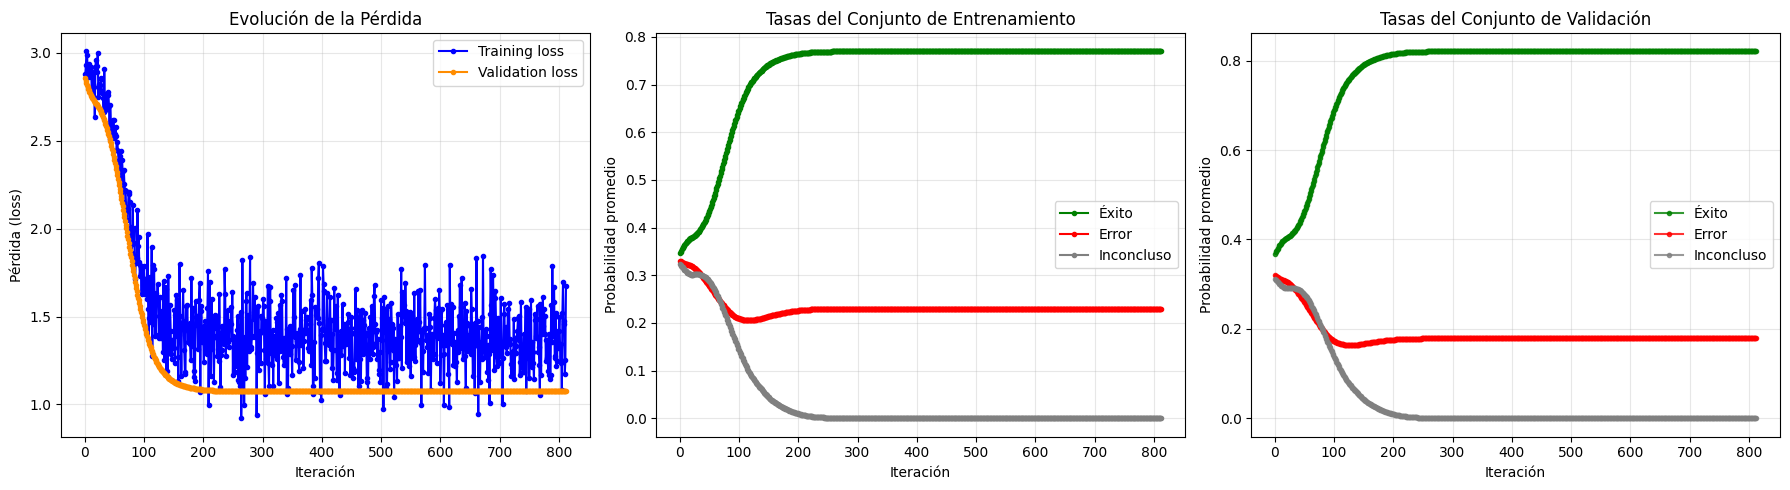

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

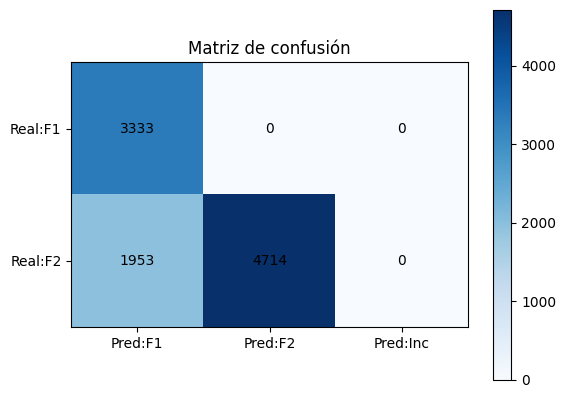

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
